In [ ]:
# loading GWSNR class from the gwsnr package
from gwsnr import GWSNR
import numpy as np

# initializing the GWSNR class with default configuration and interpolation method
gwsnr = GWSNR(mtot_min=2., mtot_max=6., mtot_max=6., ifos=['L1', 'H1', 'V1'])

# 1. Analytical Method
d_hor_analytical = gwsnr.horizon_distance_analytical(mass_1=1.4, mass_2=1.4)

# 2. Numerical Method
d_hor_numerical, _, _ = gwsnr.horizon_distance_numerical(mass_1=1.4, mass_2=1.4)


Initializing GWSNR class...

Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_0.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation_no_spins
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 6.0
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectr

In [15]:
# print the type of the SNRs
print(f"horizon distance (analytical): {d_hor_analytical} Mpc")
print(f"horizon distance (numerical): {d_hor_numerical} Mpc")

horizon distance (analytical): {'L1': array([416.49490771]), 'H1': array([416.49490771]), 'V1': array([317.93916075])} Mpc
horizon distance (numerical): {'L1': 416.49483499582857, 'H1': 416.4948722301051, 'V1': 228.76581222284585, 'optimal_snr_net': 557.9508489044383} Mpc


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Example cosmology: FlatLambdaCDM (change if your package provides another)
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.cosmology import z_at_value

# loading GWSNR class from the gwsnr package
from gwsnr import GWSNR

# initializing the GWSNR class with default configuration and interpolation method
gwsnr = GWSNR(mtot_min=2., mtot_max=6., mtot_max=6., ifos=['L1', 'H1', 'V1'])

# Define cosmology
cosmo = FlatLambdaCDM(H0=67.7, Om0=0.307)

# Define mass ranges
mass_1_range = np.linspace(1.0, 3.0, 100)
mass_2_range = np.linspace(1.0, 3.0, 100)   

# Calculate horizon distances for varying masses
d_hor_analytical = gwsnr.horizon_distance_analytical(mass_1=mass_1_range, mass_2=mass_2_range)
D_hor = d_hor_analytical['L1']  # Array of horizon distances (Mpc)
# Compute min and max redshift
z_min = z_at_value(cosmo.luminosity_distance, D_hor.min() * u.Mpc)
z_max = z_at_value(cosmo.luminosity_distance, D_hor.max() * u.Mpc)



Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be generated for H1 detector at ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be generated for V1 detector at ./interpolator_pickle/V1/partialSNR_dict_0.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['L1', 'H1', 'V1'] detectors


100%|██████████████████████████████████████████████████████████| 3996/3996 [00:23<00:00, 170.45it/s]



Saving Partial-SNR for L1 detector with shape (20, 200)

Saving Partial-SNR for H1 detector with shape (20, 200)

Saving Partial-SNR for V1 detector with shape (20, 200)

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation_no_spins
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 6.0
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_asd.

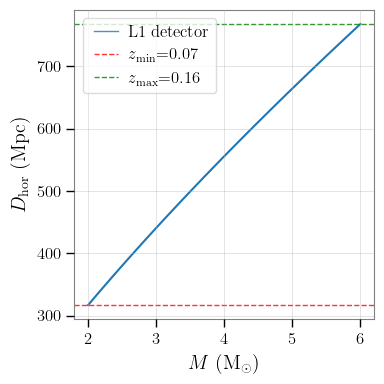

In [ ]:
# Plotting
# Setup the figure
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12
})
plt.figure(figsize=(4., 4.))

total_mass = mass_1_range + mass_2_range  # Total mass array
plt.plot(total_mass, D_hor, label='L1 detector', color='C0')
# plt.title('Horizon Distance vs Total Mass\nwithin\nthe BNS total-mass range of 2–6 M$_\odot$')
plt.xlabel(r'$M$ (M$_\odot$)')
plt.ylabel(r'$D_{\rm hor}$ (Mpc)')
plt.grid(alpha=0.5)
plt.legend()

z_min_label = r'$z_{\rm min}$=' + f'{z_min:.3f}'
z_max_label = r'$z_{\rm max}$=' + f'{z_max:.3f}'
plt.axhline(y=cosmo.luminosity_distance(z_min), color='r', linestyle='--', label=z_min_label, linewidth=1, alpha=0.8)
plt.axhline(y=cosmo.luminosity_distance(z_max), color='g', linestyle='--', label=z_max_label, linewidth=1, alpha=0.8)

# Get the legend object first
legend = plt.legend(['L1 detector', z_min_label, z_max_label], handlelength=2, loc='upper left', bbox_to_anchor=(0.0, 1.0), frameon=True, fontsize=12, edgecolor='lightgray')

# Modify line width for legend entries
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
for handle in legend.get_lines():
    handle.set_linewidth(1)
    handle.set_alpha(0.8)
plt.tight_layout()
plt.savefig('../_static/horizon_distance_vs_total_mass.png')
plt.show()

In [1]:
from ler.image_properties import ImageProperties

ler = ImageProperties()

GWSNR: Setting multiprocessing start method to 'fork'.
If you need to use the 'spawn' method (in case error or warning due to other library dependencies),
set the environment variable GWSNR_USE_SPAWN=True *before* running your script.
Command line (single line):
    GWSNR_USE_SPAWN=True python yourscript.py
In a Python script (before importing GWSNR):
    import os
    os.environ['GWSNR_USE_SPAWN'] = 'True'
    import gwsnr

luminosity_distance_to_z interpolator will be loaded from ./interpolator_pickle/luminosity_distance_to_z/luminosity_distance_to_z_0.pickle


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# loading GWSNR class from the gwsnr package
from gwsnr import GWSNR

# initializing the GWSNR class with default configuration and interpolation method
gwsnr = GWSNR(mtot_min=2., mtot_max=6., ifos=['L1', 'H1', 'V1'])

# Define mass for GW150914
mass_1 = 1.4
mass_2 = 1.4

# Calculate horizon distances for varying masses
d_hor_numerical, _, _ = gwsnr.horizon_distance_numerical(mass_1=mass_1, mass_2=mass_2)



Initializing GWSNR class...

Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/partialSNR_dict_3.pickle
Interpolator will be generated for H1 detector at ./interpolator_pickle/H1/partialSNR_dict_3.pickle
Interpolator will be generated for V1 detector at ./interpolator_pickle/V1/partialSNR_dict_3.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['L1', 'H1', 'V1'] detectors


100%|██████████████████████████████████████████████████████████| 3996/3996 [00:23<00:00, 167.21it/s]



Saving Partial-SNR for L1 detector with shape (20, 200)

Saving Partial-SNR for H1 detector with shape (20, 200)

Saving Partial-SNR for V1 detector with shape (20, 200)

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation_no_spins
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 6.0
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt', asd_file='N

In [3]:
D_hor_L1 = d_hor_numerical['L1']  # Array of horizon distances (Mpc)
D_hor_H1 = d_hor_numerical['H1']  # Array of horizon distances (Mpc)
D_hor_V1 = d_hor_numerical['V1']  # Array of horizon distances (Mpc)
D_hor_L1H1V1 = d_hor_numerical['optimal_snr_net']  # Array of horizon distances (Mpc)

In [13]:
# Compute min and max redshift
z_max_L1, z_max_H1, z_max_V1, z_max_L1H1V1 = ler.luminosity_distance_to_z(np.array([D_hor_L1, D_hor_H1, D_hor_V1, D_hor_L1H1V1]))
z_max_L1, z_max_H1, z_max_V1, z_max_L1H1V1 

(0.09103259983627375,
 0.09103260702450684,
 0.05140484220065359,
 0.11964953348303396)

In [7]:
# # create a bar plot

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],    
#     "font.size": 12
# })
# plt.figure(figsize=(4., 4.))    

# plt.bar(['L1', 'H1', 'V1', 'L1+H1+V1'],
#         [D_hor_L1, D_hor_H1, D_hor_V1, D_hor_L1H1V1],
#         color=['C0', 'C1', 'C2', 'C3'],
#         alpha=0.8)  
# plt.ylabel(r'$D_{\rm hor}$ (Mpc)')
# plt.xlabel('Detector')
# plt.tight_layout()
# plt.savefig('../_static/horizon_distance_for_GW150914.png')
# plt.show()
        

In [8]:
# loading GWSNR class from the gwsnr package
from gwsnr import GWSNR

# initializing the GWSNR class with default configuration and interpolation method
gwsnr = GWSNR(mtot_min=2., mtot_max=6., ifos=['ET'])

# Define mass for GW150914
mass_1 = 1.4
mass_2 = 1.4

# Calculate horizon distances for varying masses
d_hor_numerical, _, _ = gwsnr.horizon_distance_numerical(mass_1=mass_1, mass_2=mass_2)

D_hor_ET = d_hor_numerical['optimal_snr_net']  # Array of horizon distances (Mpc)


Initializing GWSNR class...

Interpolator will be loaded for ET1 detector from ./interpolator_pickle/ET1/partialSNR_dict_1.pickle
Interpolator will be loaded for ET2 detector from ./interpolator_pickle/ET2/partialSNR_dict_1.pickle
Interpolator will be loaded for ET3 detector from ./interpolator_pickle/ET3/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation_no_spins
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 6.0
detectors:  ['ET1', 'ET2', 'ET3']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity

In [9]:
z_max_ET = ler.luminosity_distance_to_z(np.array([D_hor_ET]))[0]
z_max_ET

0.9858398077620325

In [10]:
# loading GWSNR class from the gwsnr package
from gwsnr import GWSNR

# initializing the GWSNR class with default configuration and interpolation method
gwsnr = GWSNR(mtot_min=2., mtot_max=6., ifos=['ET', 'CE'])


# Define mass for GW150914
mass_1 = 1.4
mass_2 = 1.4

# Calculate horizon distances for varying masses
d_hor_numerical, _, _ = gwsnr.horizon_distance_numerical(mass_1=mass_1, mass_2=mass_2)

D_hor_CE = d_hor_numerical['CE']  # Array of horizon distances (Mpc)
D_hor_ETCE = d_hor_numerical['optimal_snr_net']  # Array of horizon distances (Mpc)


Initializing GWSNR class...

Interpolator will be loaded for ET1 detector from ./interpolator_pickle/ET1/partialSNR_dict_1.pickle
Interpolator will be loaded for ET2 detector from ./interpolator_pickle/ET2/partialSNR_dict_1.pickle
Interpolator will be loaded for ET3 detector from ./interpolator_pickle/ET3/partialSNR_dict_1.pickle
Interpolator will be loaded for CE detector from ./interpolator_pickle/CE/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation_no_spins
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 6.0
detectors:  ['ET1', 'ET2', 'ET3', 'CE']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/pyth

In [11]:
z_max_CE = ler.luminosity_distance_to_z(np.array([D_hor_CE]))[0]
z_max_ETCE = ler.luminosity_distance_to_z(np.array([D_hor_ETCE]))[0]
print(f"z_max_CE: {z_max_CE}, z_max_ETCE: {z_max_ETCE}")

z_max_CE: 1.9743360027490944, z_max_ETCE: 1.8204629046823522


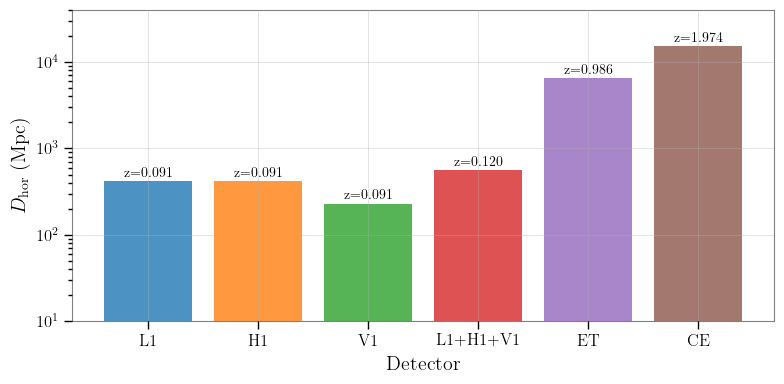

In [15]:
# create a bar plot

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],    
    "font.size": 12
})
plt.figure(figsize=(8., 4.))    

bars = plt.bar(['L1', 'H1', 'V1', 'L1+H1+V1', 'ET', 'CE'],
    [D_hor_L1, D_hor_H1, D_hor_V1, D_hor_L1H1V1, D_hor_ET, D_hor_CE],
    color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5'],
    alpha=0.8)

# Add z values at the top of each bar
z_values = [z_max_L1, z_max_H1, z_max_L1, z_max_L1H1V1, z_max_ET, z_max_CE]
for bar, z_val in zip(bars, z_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.05, 
         f'z={z_val:.3f}', ha='center', va='bottom', fontsize=10)

plt.ylabel(r'$D_{\rm hor}$ (Mpc)')
plt.xlabel('Detector')
plt.yscale('log')
plt.ylim(10., 40000.)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../_static/horizon_distance_for_BNS.png')
plt.show()